In [1]:
import os
from os import path
from astropy.time import Time
from astropy.io import fits, ascii
import astropy.units as u
from astropy.table import Table
from astropy.constants import G

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [2]:
# allstar = fits.getdata('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58104.fits')
allstar = fits.getdata('/Users/adrian/data/APOGEE_DR14/allStar-l31c.2.fits')

In [3]:
starflag_mask = np.sum(2 ** np.array([9, 12, 13, # PERSIST_HIGH, PERSIST_JUMP_POS, PERSIST_JUMP_NEG
                                      3, 4])) # VERY_BRIGHT_NEIGHBOR, LOW_SNR
aspcap_mask = np.sum(2 ** np.array([7, 23])) # STAR_WARN, STAR_BAD

mask = (((allstar['ASPCAPFLAG'] & aspcap_mask) == 0) &
        ((allstar['STARFLAG'] & starflag_mask) == 0) &
        (allstar['MG_FE'] > -999) &
        (allstar['NA_FE'] > -999) & 
        (allstar['CA_FE'] > -999) & 
        (allstar['LOGG'] > -999) & 
        (allstar['TEFF'] > -999) & 
        (allstar['M_H'] > -0.5) & # Metallicity cut!
        (allstar['TEFF'] > 4000) & # T_eff cut!
        (allstar['LOGG'] > 2.5))
        
stars = allstar[mask]
len(stars)

32067

In [4]:
per_Fe_names = []
for name in stars.dtype.names:
    if '_FE' in name and '_ERR' not in name and 'FEH' not in name and 'FLAG' not in name:
        per_Fe_names.append(name)
per_Fe_names = np.array(per_Fe_names)
per_Fe_names

array(['C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE',
       'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE',
       'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CU_FE', 'GE_FE', 'RB_FE',
       'Y_FE', 'ND_FE'],
      dtype='<U7')

In [5]:
# Note: more correct? https://github.com/megbedell/q2/blob/master/abundances.py
lodders = ascii.read('/Users/adrian/Downloads/Lodders2003.txt', delimiter=',')
lodders['elem'] = [n.lower() for n in lodders['elem']]

In [6]:
per_Fe_Tc = []
good_Tc = []
for i, name in enumerate(per_Fe_names):
    _name = name.lower().split('_')[0]
    Tc = lodders['Tc_50'][lodders['elem'] == _name]
    if len(Tc) == 0: 
        per_Fe_Tc.append(np.nan)
    else:
        per_Fe_Tc.append(Tc[0])
    
per_Fe_Tc = np.array(per_Fe_Tc)

In [7]:
elem_names = np.append(per_Fe_names[np.isfinite(per_Fe_Tc)], 'FE_H')
elem_Tc = np.append(per_Fe_Tc[np.isfinite(per_Fe_Tc)], 1334.0)

In [8]:
x = elem_Tc
all_y = np.zeros((len(stars), len(elem_names)))
all_err = np.zeros((len(stars), len(elem_names)))

for i, name in enumerate(elem_names):
    all_y[:, i] = stars[name] - stars['M_H']
    all_err[:, i] = np.sqrt(stars[name + '_ERR']**2 + stars['M_H_ERR']**2)

all_y.shape

(32067, 23)

TODO: 
* try an outlier model with a prior to low numbers of outliers
* try a model with extra variance

In [17]:
n_stars, n_elems = all_y.shape

all_ab = np.zeros((n_stars, 2))
all_Cov = np.zeros((n_stars, 2, 2))
all_res = np.zeros((n_stars, ))
all_chi2 = np.zeros((n_stars, ))

for n in range(n_stars):
    n_mask = (all_y[n] > -999) & (x > 900.) # only fit elements with TC > 900 K
    y = all_y[n, n_mask]
    err = all_err[n, n_mask]
    
    A = np.vander(x[n_mask], N=2)
    # a, b = np.linalg.lstsq(A, y)[0]
    Cinv = np.diag(1/err**2)
    C = np.linalg.inv(A.T @ Cinv @ A)
    
    all_ab[n] = C @ (A.T @ Cinv @ y)
    all_Cov[n] = C
    all_res[n] = np.sum( ((all_ab[n,0]*x[n_mask] + all_ab[n,1]) - y)**2 )
    all_chi2[n] = np.sum( ((all_ab[n,0]*x[n_mask] + all_ab[n,1]) - y)**2 / err**2 )

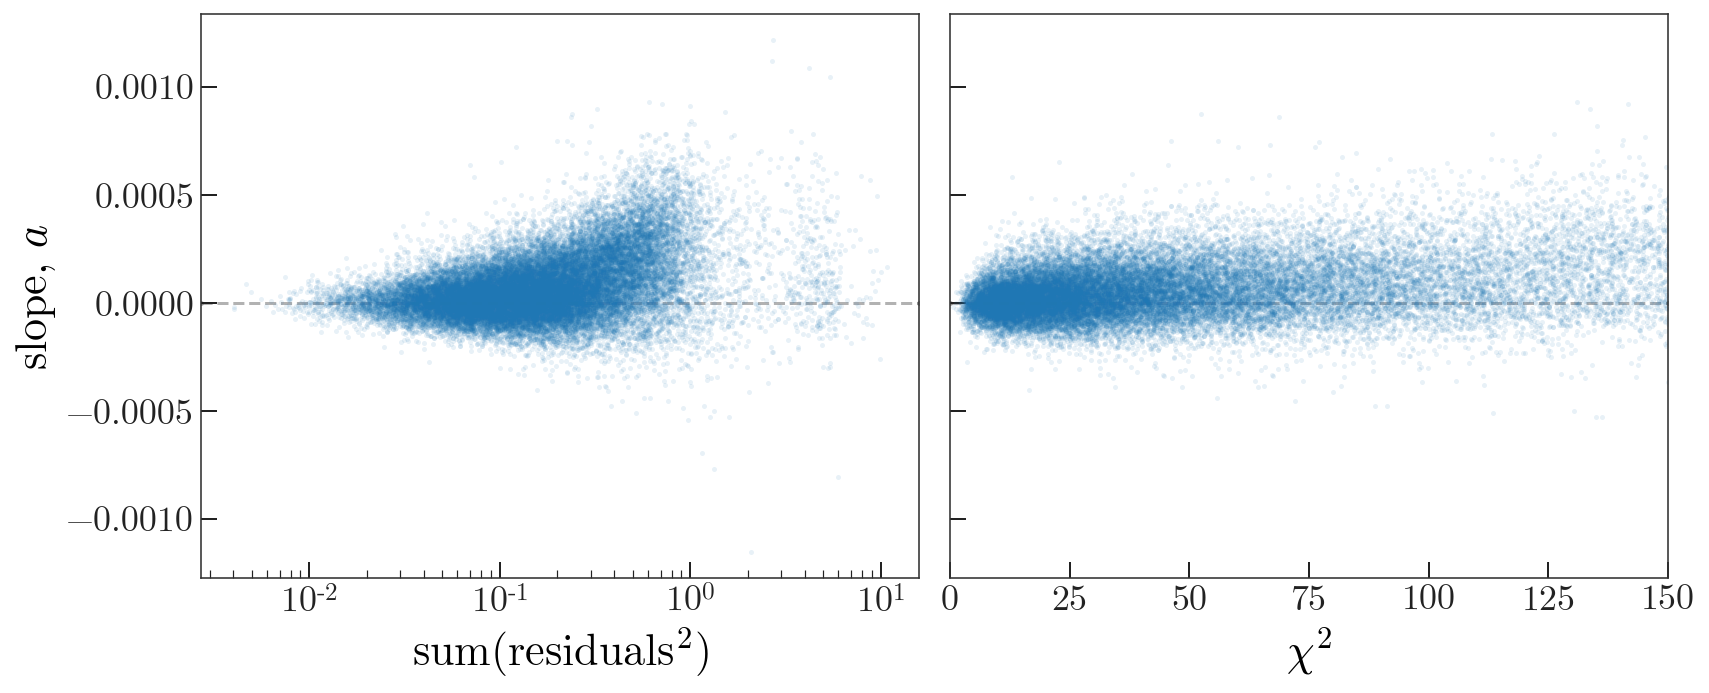

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].plot(all_res, all_ab[:, 0], marker='.', linestyle='', alpha=0.1)
axes[0].set_xscale('log')
axes[0].set_xlabel('sum(residuals$^2$)')
axes[0].set_ylabel('slope, $a$')
axes[0].axhline(0., zorder=-10, alpha=0.5, linestyle='dashed')

axes[1].plot(all_chi2, all_ab[:, 0], marker='.', linestyle='', alpha=0.1)
# axes[1].set_xscale('log')
axes[1].set_xlabel(r'$\chi^2$')
axes[1].axhline(0., zorder=-10, alpha=0.5, linestyle='dashed')
axes[1].set_xlim(0, 150)

fig.tight_layout()

In [37]:
# ab_mask = (all_res < 2E-2) & (all_ab[:, 0] > 1E-4)
ab_mask = (all_chi2 < 10) & (all_ab[:, 0] > 2E-4)
ab_mask.sum()

22

We only fit with elements with $T_C > 900~{\rm K}$, even though elements with $T_C > 500~{\rm K}$ are plotted:

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


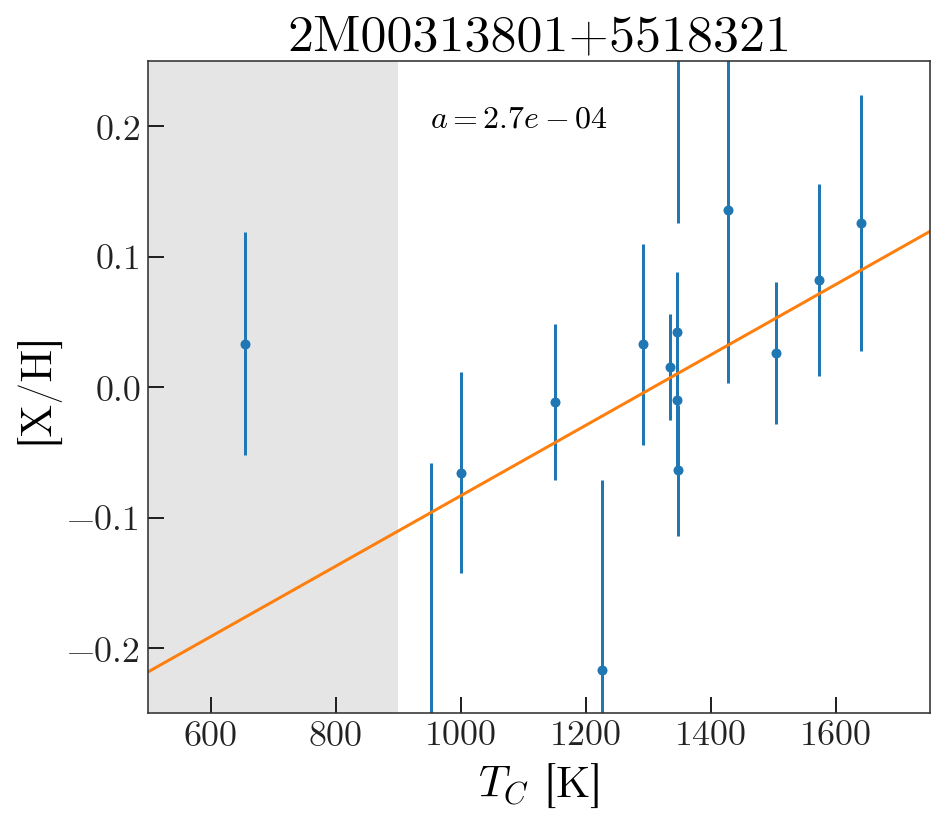

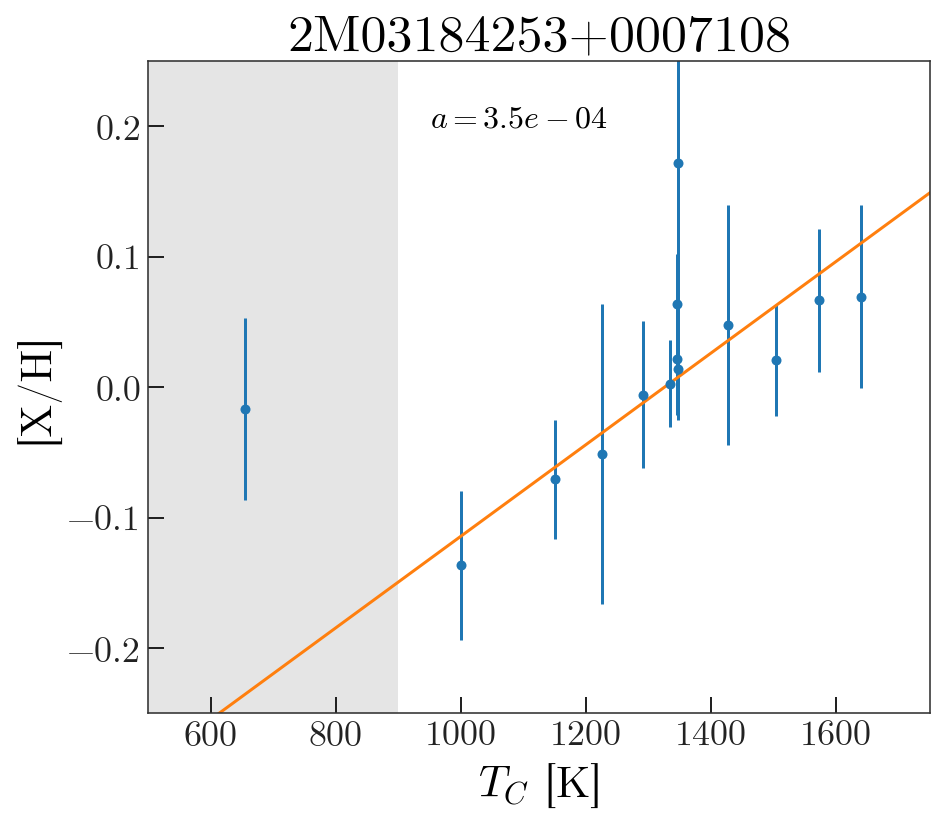

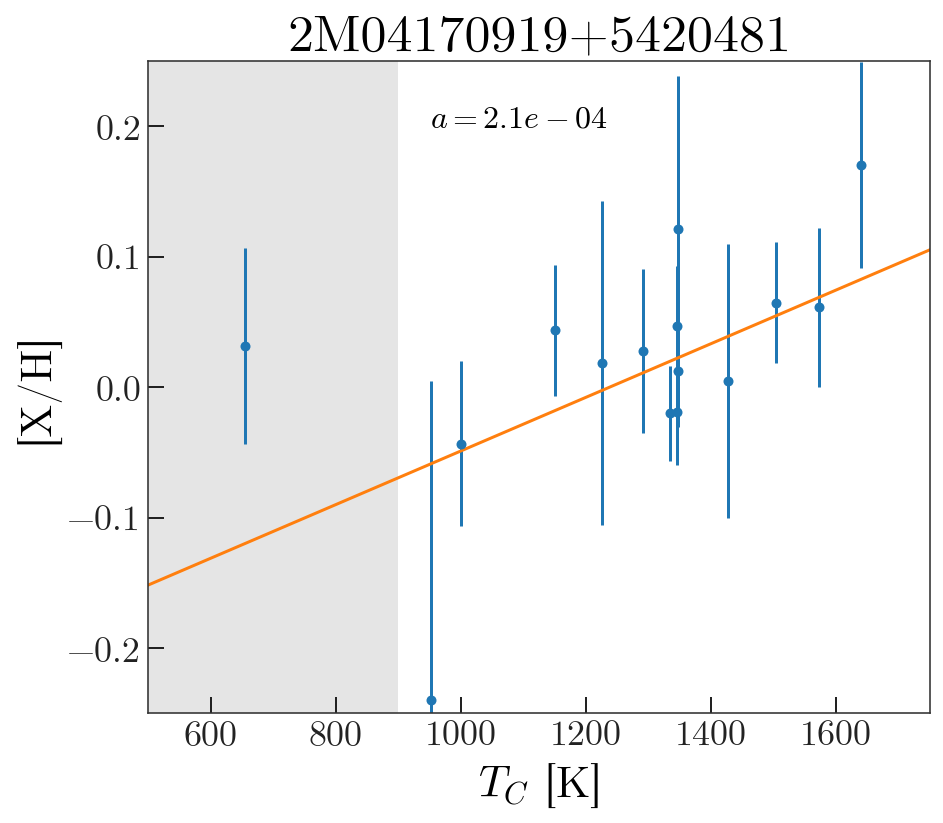

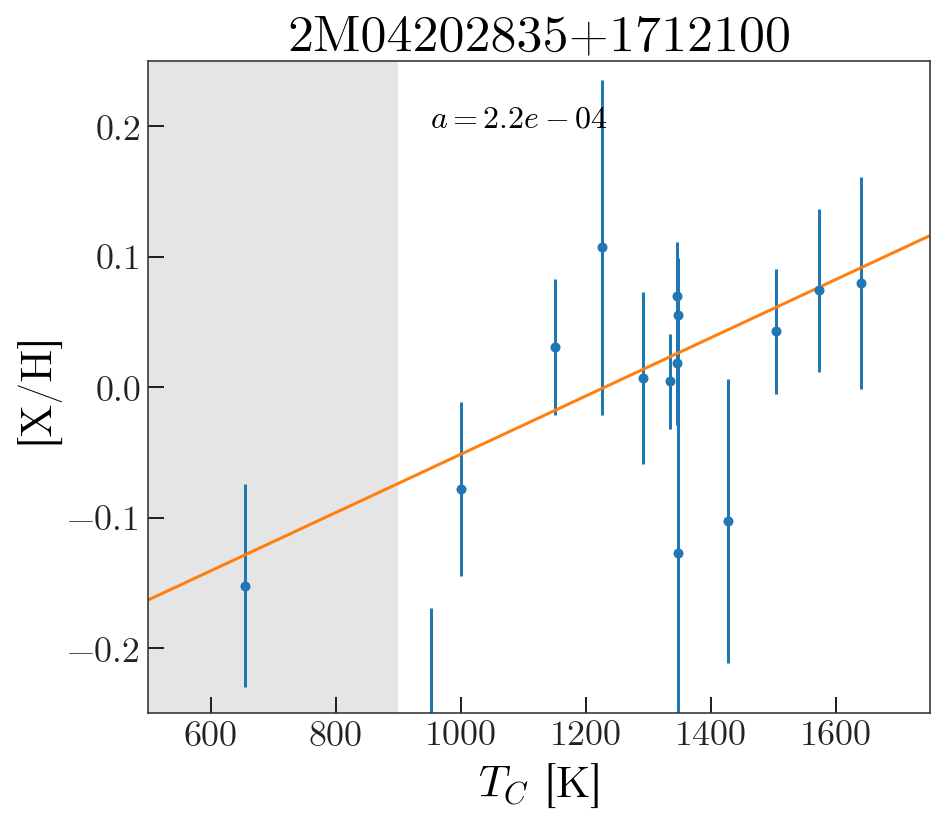

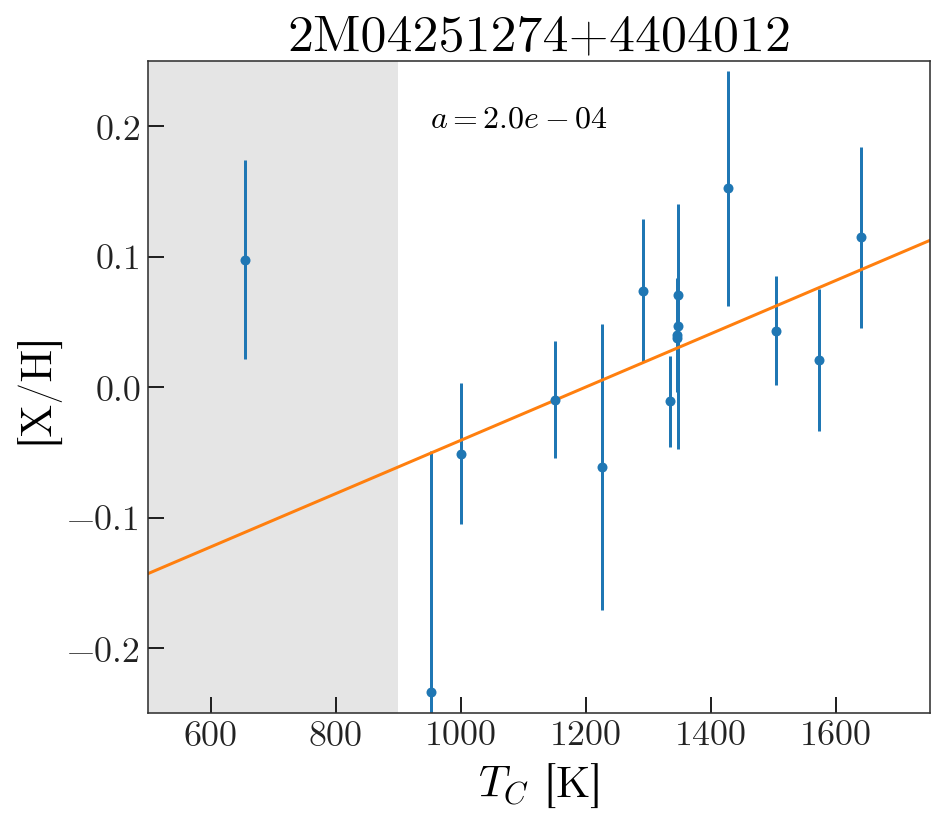

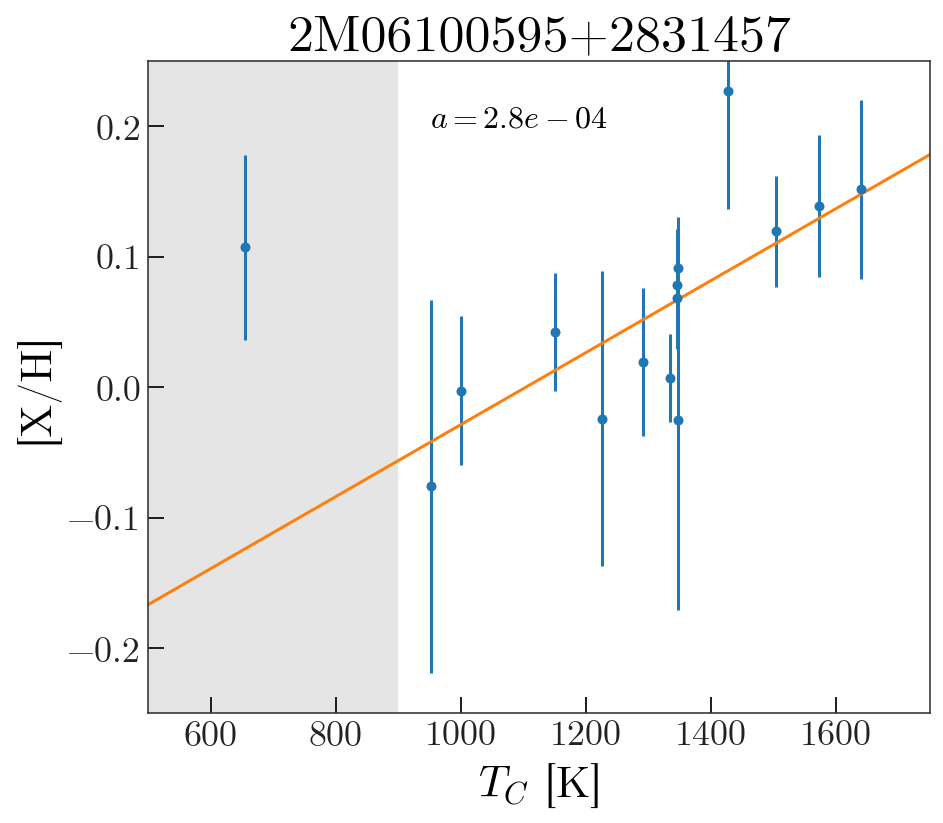

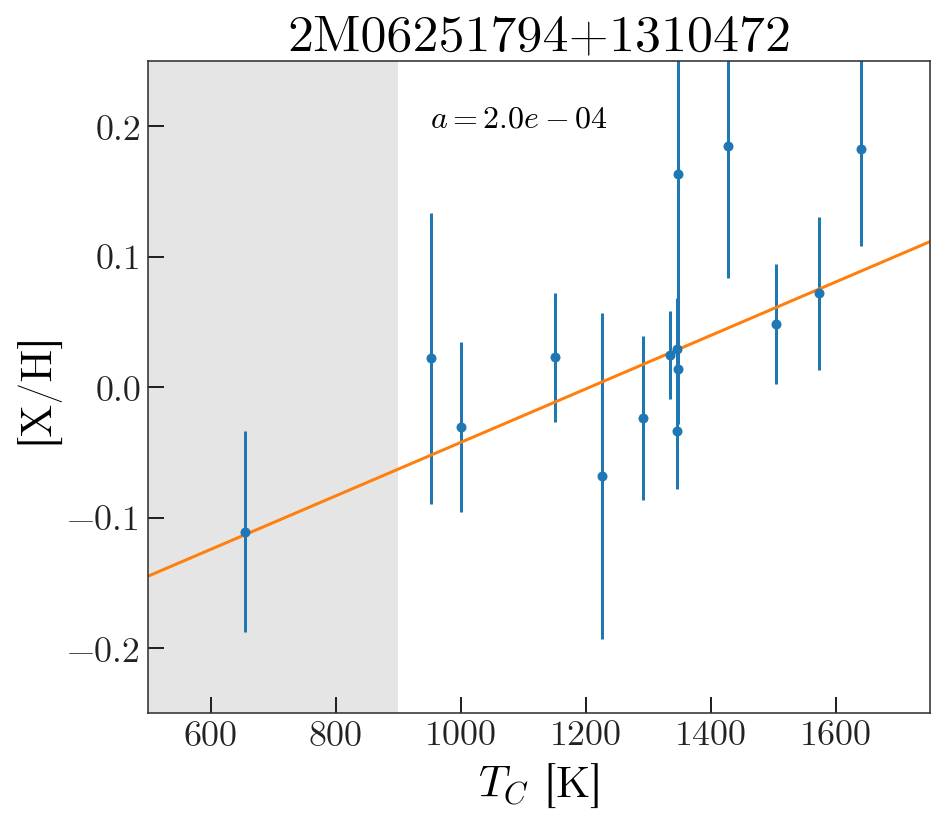

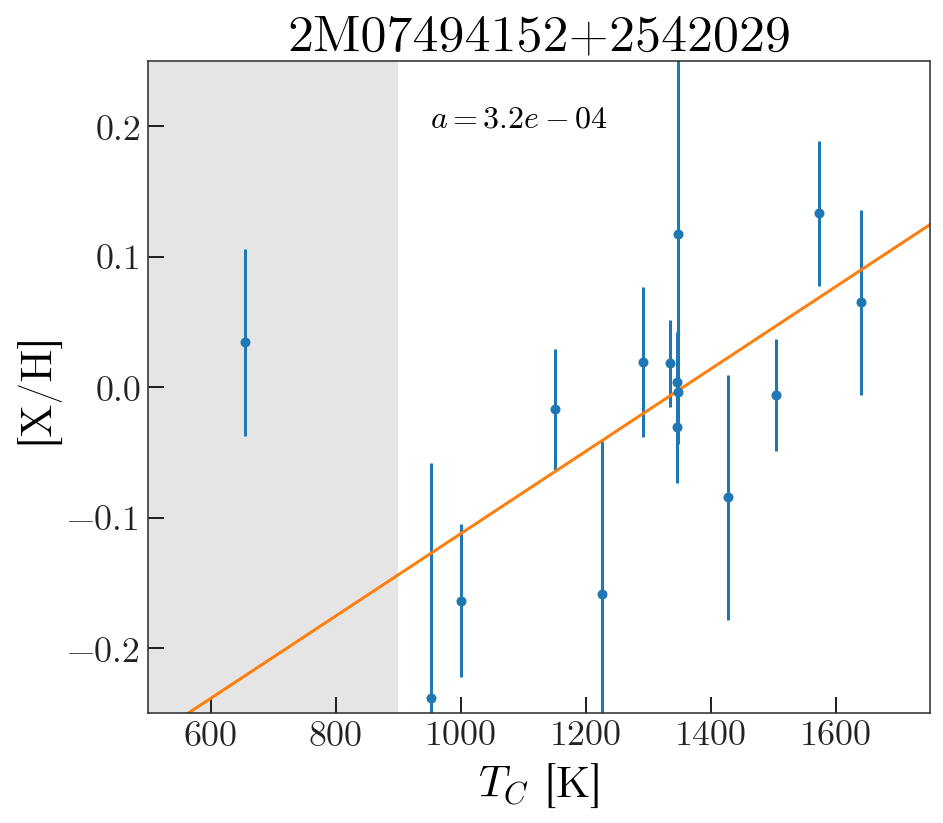

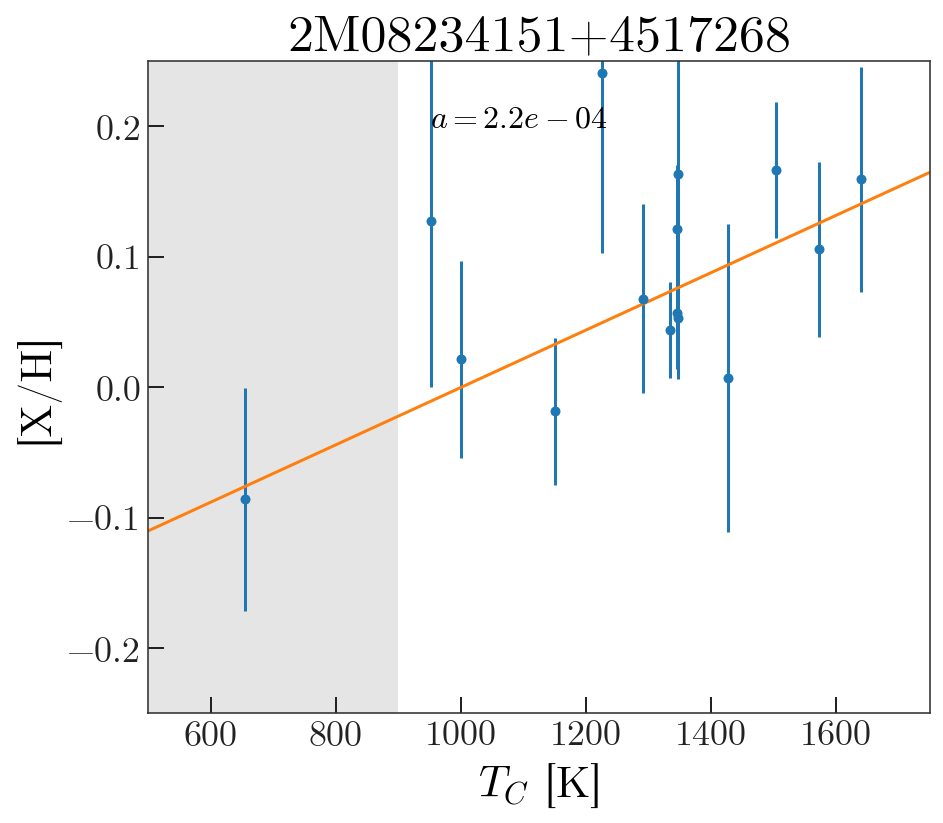

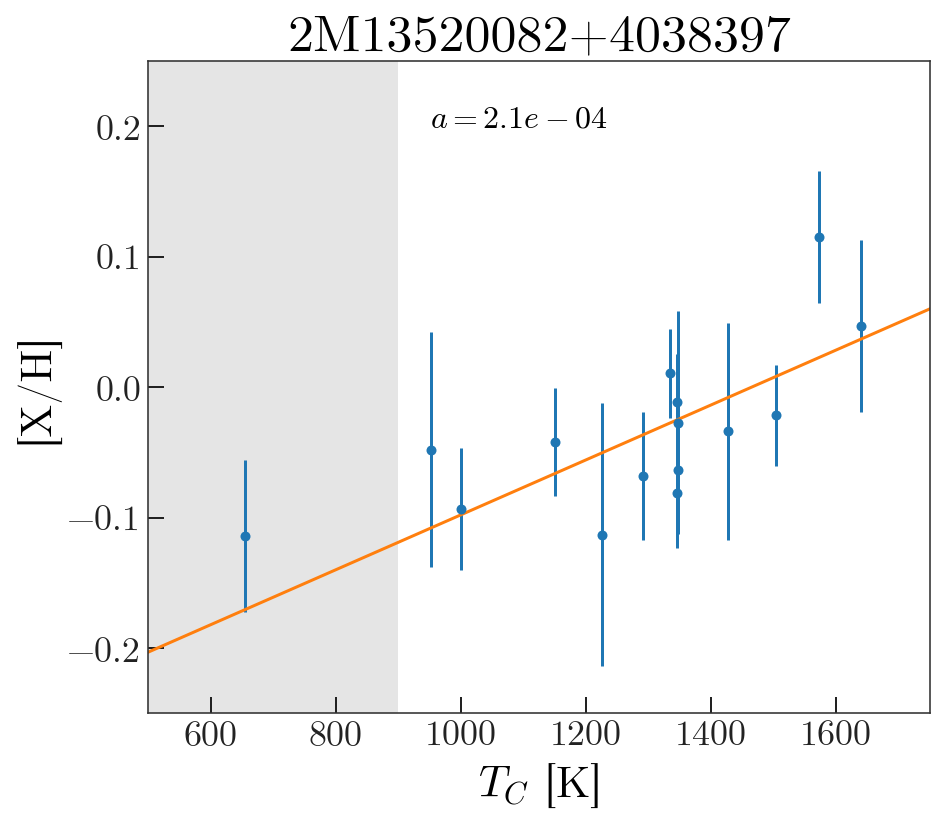

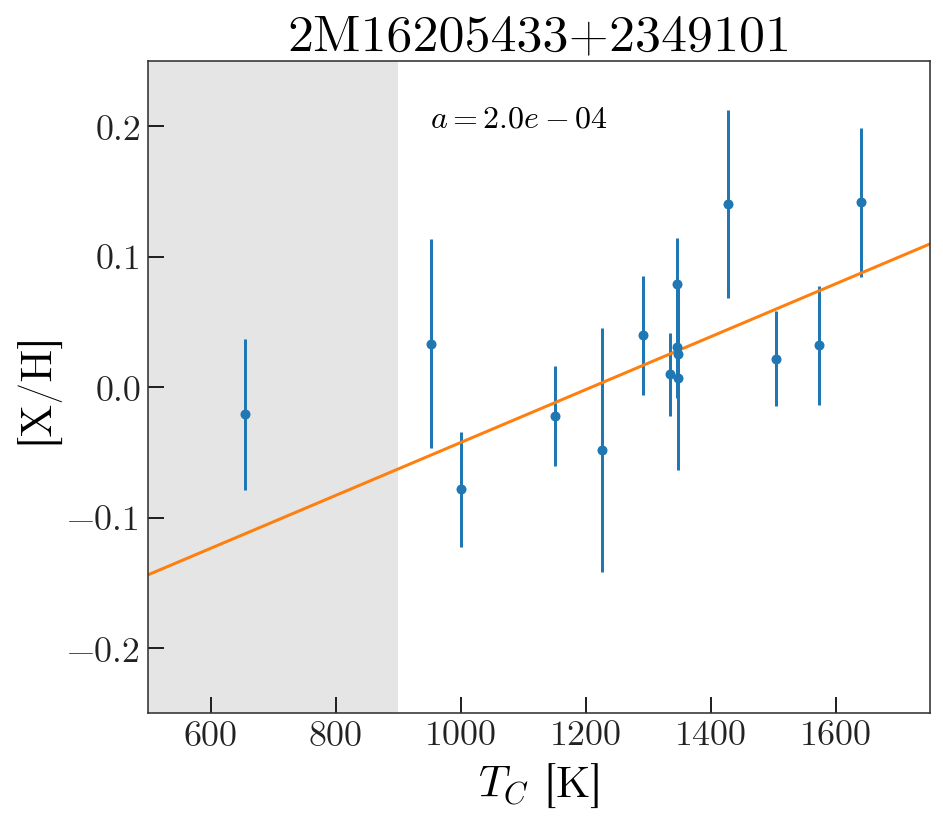

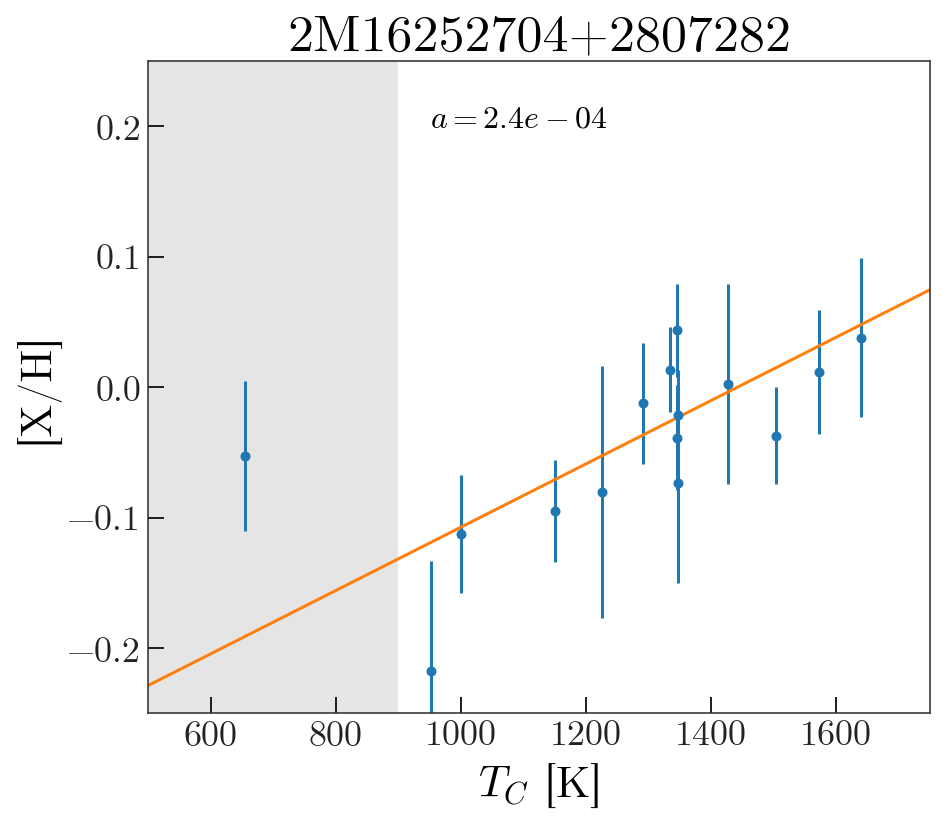

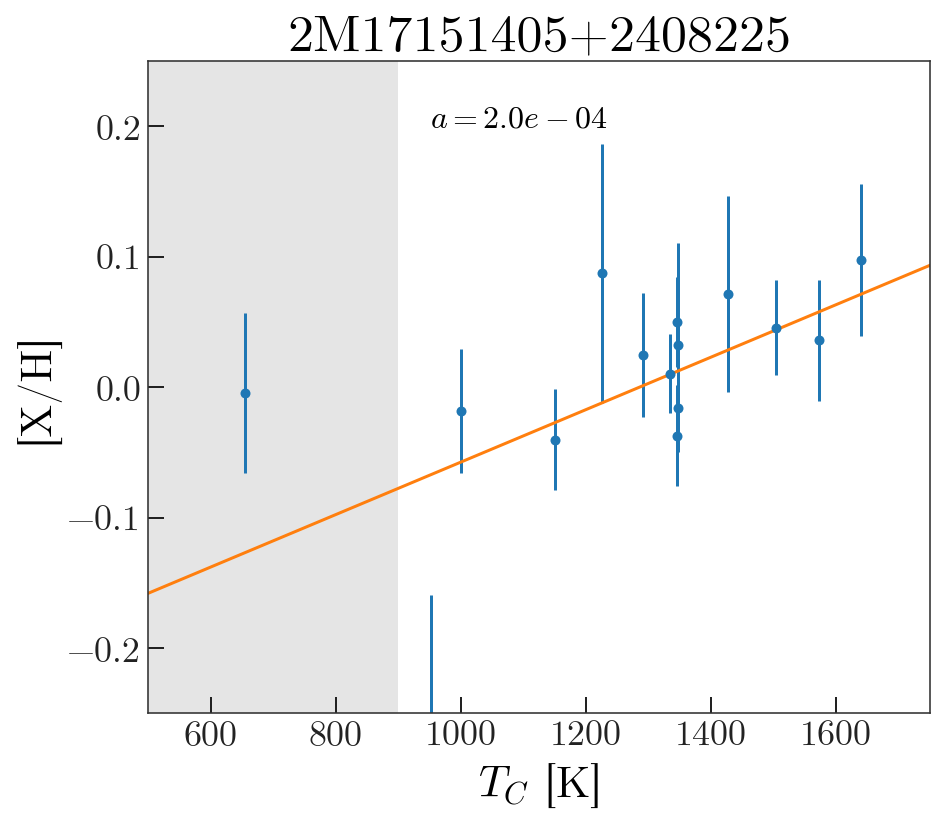

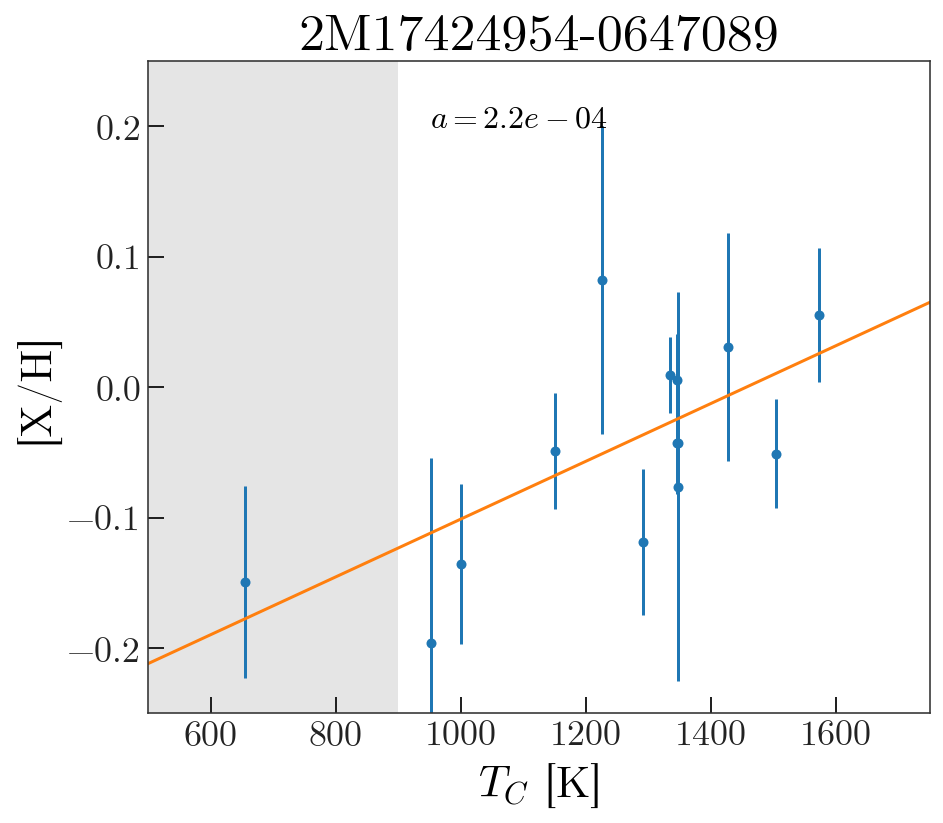

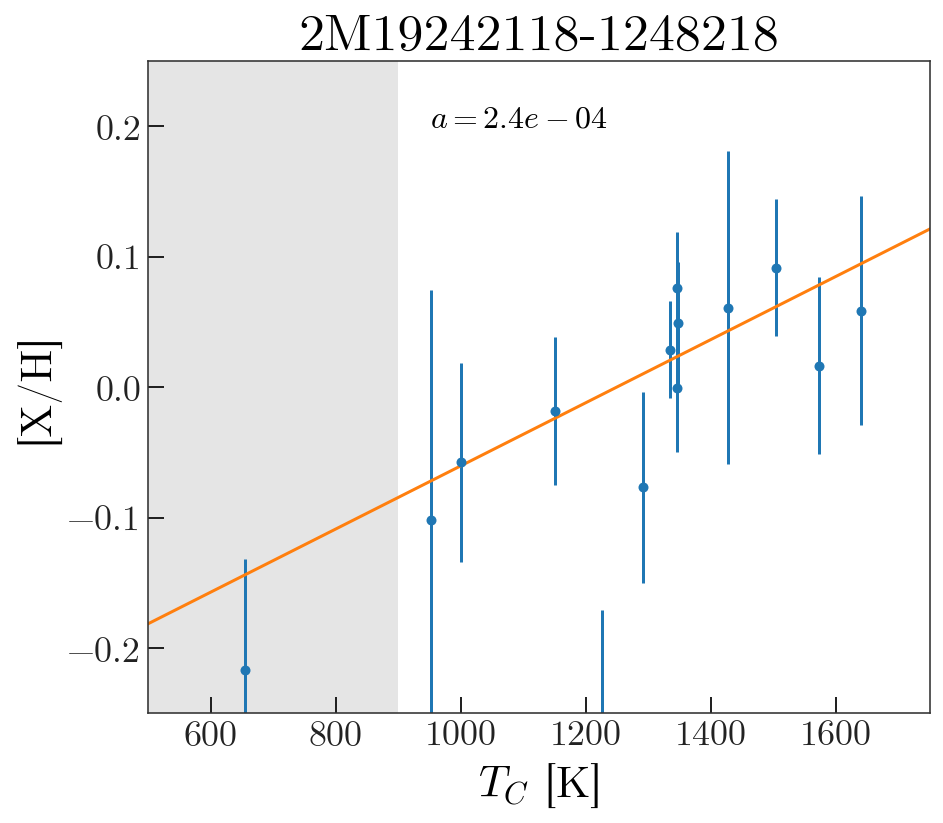

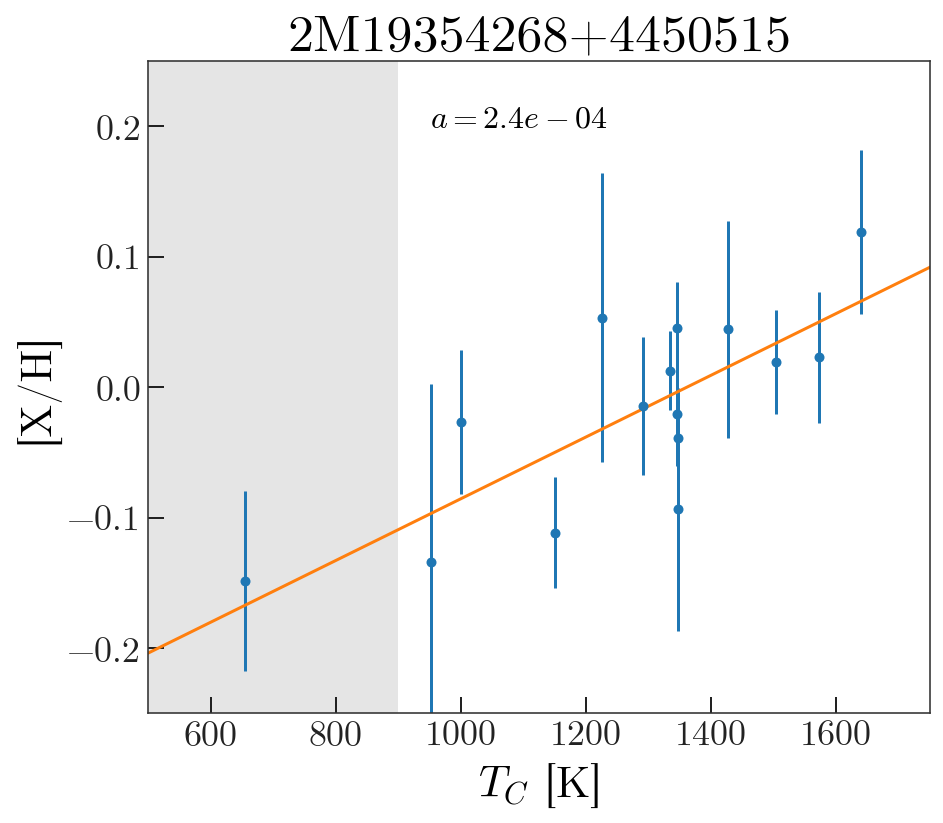

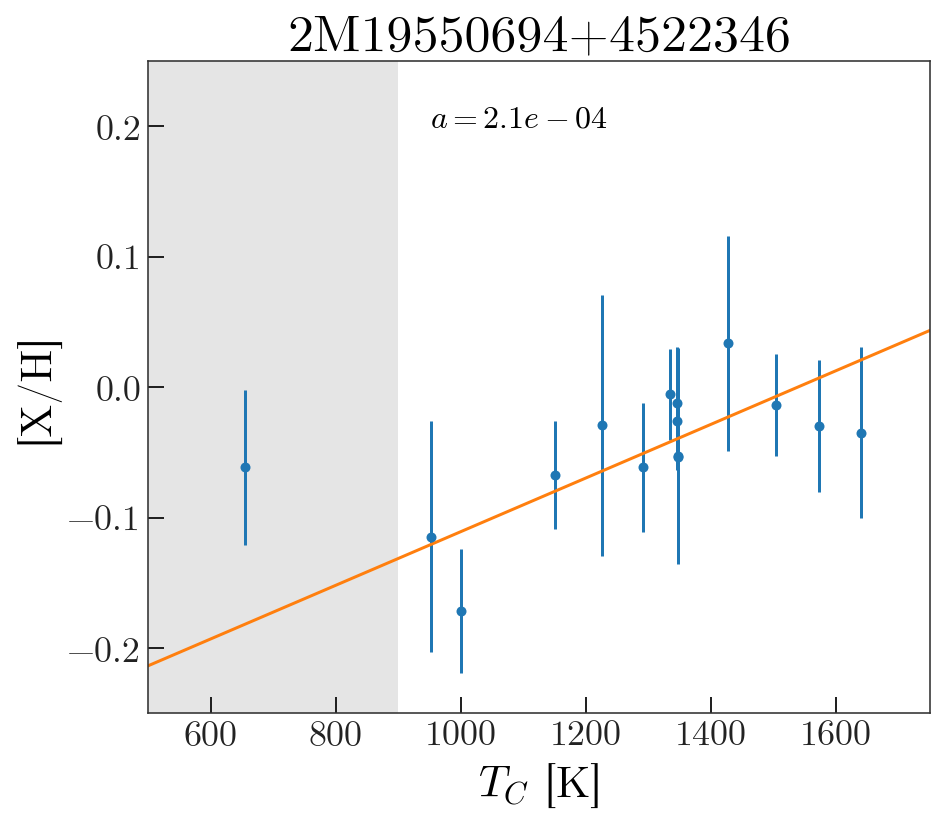

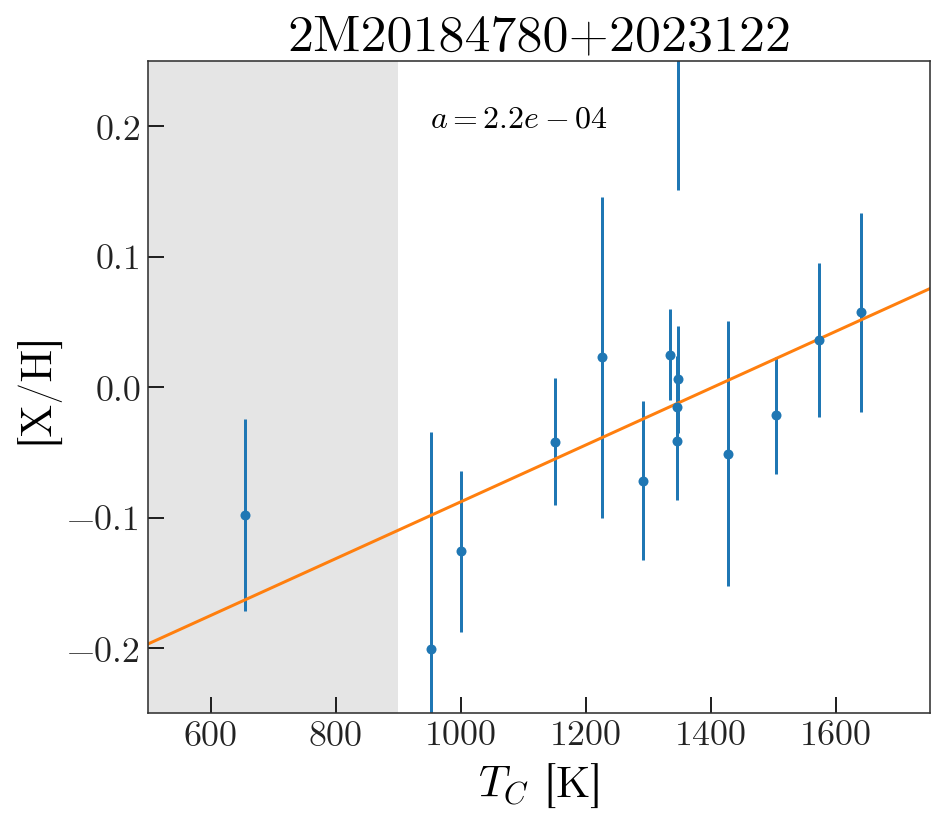

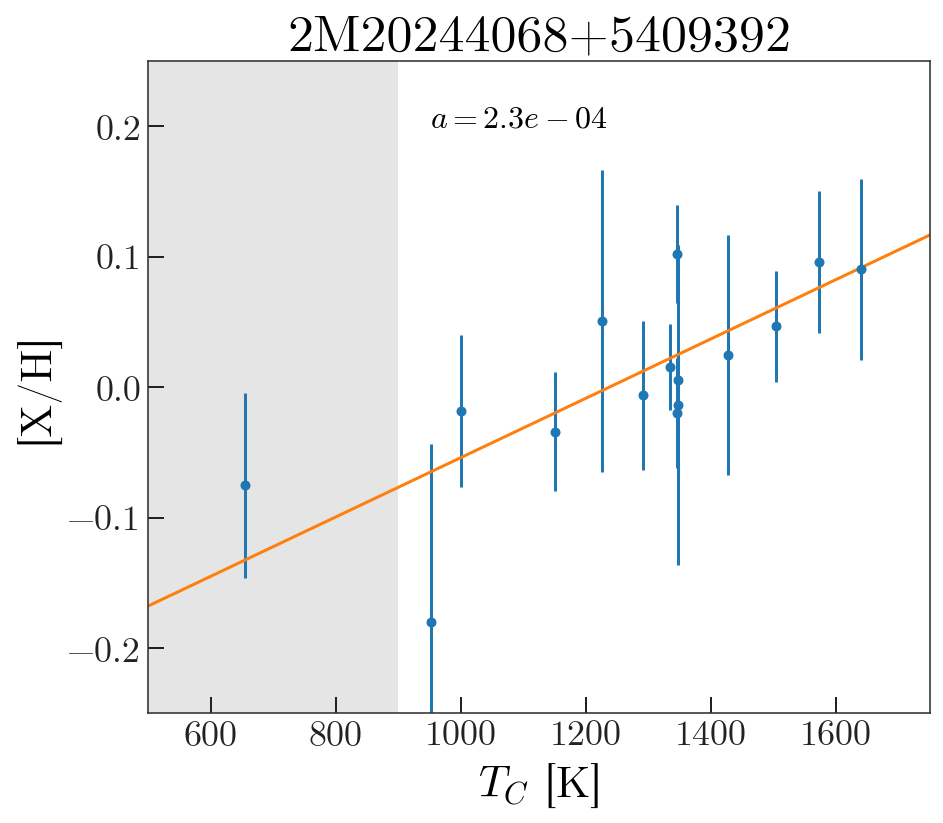

In [ ]:
x_grid = np.linspace(500, 1800, 16)

for n in np.where(ab_mask)[0]:
    n_mask = (all_y[n] > -999) & (x > 500.)
    y = all_y[n, n_mask]
    err = all_err[n, n_mask]
    a, b = all_ab[n]
    
    plt.figure(figsize=(7,6))
    plt.errorbar(x[n_mask], y, err, marker='o', linestyle='none')
    plt.axvline
    plt.plot(x_grid, a*x_grid + b, marker='')
    plt.text(950, 0.2, '$a = {0:.1e}$'.format(a), fontsize=16)
    plt.xlabel('$T_C$ [K]')
    plt.ylabel('[X/H]')
    plt.title(stars[n]['APOGEE_ID'])
    plt.xlim(500, 1750)
    plt.ylim(-0.25, 0.25)
    plt.axvspan(0, 900, color='#555555', alpha=0.15, zorder=-1, linewidth=0)